In [29]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import imageio
import re


class KITTIDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_names = []
        self.mask_names = []

        if masks_dir:
            
            for img_name in os.listdir(images_dir):
                base_name1, base_name2 = img_name.split("_")
                mask_name = f"{base_name1}_lane_{base_name2}"

                if os.path.exists(os.path.join(masks_dir, mask_name)):
                    self.image_names.append(img_name)
                    self.mask_names.append(mask_name)
        else:
            
            self.image_names = os.listdir(images_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.masks_dir:
            mask_name = self.mask_names[idx]
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path).convert("L")
            if self.mask_transform:
                mask = self.mask_transform(mask)
            return image, mask
        else:
            return image, img_name



image_transforms = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor()
])


full_train_dataset = KITTIDataset(
    images_dir="dataset/data_road/training/image_2",
    masks_dir="dataset/data_road/training/gt_image_2",
    transform=image_transforms,
    mask_transform=mask_transforms
)


train_size = int(0.8 * len(full_train_dataset))  
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


test_dataset = KITTIDataset(
    images_dir="dataset/data_road/testing/image_2",
    masks_dir=None,
    transform=image_transforms
)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        in_ch = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(in_ch, feature))
            in_ch = feature
        
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip = []
        for enc in self.encoder_blocks:
            x = enc(x)
            skip.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)

        skip = skip[::-1]
        
        for idx in range(0, len(self.decoder_blocks), 2):
            trans_conv = self.decoder_blocks[idx]
            double_conv = self.decoder_blocks[idx+1]
            x = trans_conv(x)
            
            
            if x.shape != skip[idx//2].shape:
                x = F.interpolate(x, size=skip[idx//2].shape[2:], mode='bilinear', align_corners=True)
            
            concat_skip = torch.cat((skip[idx//2], x), dim=1)
            x = double_conv(concat_skip)

        return self.final_conv(x)
model = UNet(out_channels=1)  


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2.*intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

criterion = nn.BCEWithLogitsLoss()



In [4]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.float()  
            masks = (masks > 100/255).float()  
            
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.squeeze(1)  
            loss = criterion(outputs, masks.squeeze(1))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': epoch_loss / (pbar.n + 1)})
            pbar.update(1)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
    
    
    if epoch == num_epochs - 1 or (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")


Epoch 1/20: 100%|██████████| 5/5 [03:18<00:00, 39.66s/it, loss=0.752]


Epoch 1/20, Loss: 0.7519


Epoch 2/20: 100%|██████████| 5/5 [04:09<00:00, 49.86s/it, loss=0.675]


Epoch 2/20, Loss: 0.6753


Epoch 3/20: 100%|██████████| 5/5 [04:06<00:00, 49.38s/it, loss=0.603]


Epoch 3/20, Loss: 0.6033


Epoch 4/20: 100%|██████████| 5/5 [04:03<00:00, 48.69s/it, loss=0.526]


Epoch 4/20, Loss: 0.5263


Epoch 5/20: 100%|██████████| 5/5 [03:57<00:00, 47.53s/it, loss=0.465]


Epoch 5/20, Loss: 0.4649


Epoch 6/20: 100%|██████████| 5/5 [03:18<00:00, 39.68s/it, loss=0.413]


Epoch 6/20, Loss: 0.4126


Epoch 7/20: 100%|██████████| 5/5 [03:20<00:00, 40.05s/it, loss=0.383]


Epoch 7/20, Loss: 0.3827


Epoch 8/20: 100%|██████████| 5/5 [03:22<00:00, 40.55s/it, loss=0.364]


Epoch 8/20, Loss: 0.3641


Epoch 9/20: 100%|██████████| 5/5 [04:01<00:00, 48.27s/it, loss=0.348]


Epoch 9/20, Loss: 0.3475


Epoch 10/20: 100%|██████████| 5/5 [04:10<00:00, 50.18s/it, loss=0.335]


Epoch 10/20, Loss: 0.3349


Epoch 11/20: 100%|██████████| 5/5 [03:45<00:00, 45.06s/it, loss=0.325]


Epoch 11/20, Loss: 0.3246


Epoch 12/20: 100%|██████████| 5/5 [03:41<00:00, 44.20s/it, loss=0.317]


Epoch 12/20, Loss: 0.3174


Epoch 13/20: 100%|██████████| 5/5 [03:33<00:00, 42.66s/it, loss=0.312]


Epoch 13/20, Loss: 0.3119


Epoch 14/20: 100%|██████████| 5/5 [03:55<00:00, 47.19s/it, loss=0.309]


Epoch 14/20, Loss: 0.3089


Epoch 15/20: 100%|██████████| 5/5 [04:07<00:00, 49.50s/it, loss=0.303]


Epoch 15/20, Loss: 0.3031


Epoch 16/20: 100%|██████████| 5/5 [04:49<00:00, 57.99s/it, loss=0.299]


Epoch 16/20, Loss: 0.2988


Epoch 17/20: 100%|██████████| 5/5 [03:55<00:00, 47.15s/it, loss=0.294]


Epoch 17/20, Loss: 0.2937


Epoch 18/20: 100%|██████████| 5/5 [03:24<00:00, 40.89s/it, loss=0.29] 


Epoch 18/20, Loss: 0.2900


Epoch 19/20: 100%|██████████| 5/5 [03:25<00:00, 41.18s/it, loss=0.288]


Epoch 19/20, Loss: 0.2875


Epoch 20/20: 100%|██████████| 5/5 [03:50<00:00, 46.01s/it, loss=0.287]


Epoch 20/20, Loss: 0.2873


In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size  
    image = transform(image).unsqueeze(0).to(device)  
    return image, original_size

def postprocess_output(output, original_size, threshold=0.5):
    output = output.squeeze().cpu().detach().numpy()
    output = sigmoid(output)
    output = (output > threshold).astype(np.uint8) * 255
    output = Image.fromarray(output).resize(original_size, Image.NEAREST)
    return np.array(output)

def hough_transform(image, threshold=50, min_line_length=50, max_line_gap=150):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold, 
                            minLineLength=min_line_length, 
                            maxLineGap=max_line_gap)
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_image, (x1,y1), (x2,y2), 255, 2)
    return line_image

def combine_segmentation_hough(segmentation, hough):
    combined = cv2.bitwise_and(segmentation, hough)
    return combined

def hough_transform_area(image, threshold=50, min_line_length=50, max_line_gap=150):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold, 
                            minLineLength=min_line_length, 
                            maxLineGap=max_line_gap)
    line_image = np.zeros_like(image)
    points = []
    
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                
                points.append([x1, y1])
                points.append([x2, y2])
                
                cv2.line(line_image, (x1, y1), (x2, y2), 255, 2)
    
    if points:
        
        points = np.array(points)
        hull = cv2.convexHull(points)
        area_mask = np.zeros_like(image)
        cv2.fillConvexPoly(area_mask, hull, 255)
        return area_mask
    else:
        
        return np.zeros_like(image)

def visualize_result(original_image_path, segmentation, combined, save_path=None):
    original = cv2.imread(original_image_path)
    original = cv2.resize(original, (segmentation.shape[1], segmentation.shape[0]))
    
    overlay = original.copy()
    overlay[segmentation > 0] = [0, 255, 0]

    
    cv2.addWeighted(original, 0.7, overlay, 0.3, 0, overlay)
    
    if save_path:
        cv2.imwrite(save_path, overlay)
    else:
        cv2.imshow("Lane Detection", overlay)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
def keep_largest_connected_area(mask):
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros_like(mask)

    
    largest_contour = max(contours, key=cv2.contourArea)

    
    largest_area_mask = np.zeros_like(mask)
    cv2.drawContours(largest_area_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    return largest_area_mask


In [45]:
def process_video_without_crop(input_video_path, output_video_path, transform, model, device):
    cap = cv2.VideoCapture(input_video_path)
    
    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        
        
        temp_image_path = "temp_frame.png"
        cv2.imwrite(temp_image_path, frame)
        
        
        image, original_size = preprocess_image(temp_image_path, transform)
        
        
        model.eval()
        with torch.no_grad():
            output = model(image.to(device))
        segmentation = postprocess_output(output, original_size)

        original_image = cv2.resize(frame, (segmentation.shape[1], segmentation.shape[0]))
        overlay = original_image.copy()
        overlay[segmentation > 0] = [0, 255, 0]  
        
        
        cv2.addWeighted(original_image, 0.7, overlay, 0.3, 0, overlay)
        
        
        final_frame = cv2.resize(overlay, (frame_width, frame_height))
        
        
        out.write(final_frame)
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    if os.path.exists("temp_frame.png"):
        os.remove("temp_frame.png")
        
def process_video(input_video_path, output_video_path, transform, model, device):
    cap = cv2.VideoCapture(input_video_path)

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    
    target_width = 1242
    target_height = 375
    target_ratio = target_width / target_height

    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        
        
        current_ratio = frame_width / frame_height

        
        if abs(current_ratio - target_ratio) < 1e-3:
            
            cropped_frame = frame
            x_offset, y_offset = 0, 0
            crop_w, crop_h = frame_width, frame_height
        elif current_ratio > target_ratio:
            
            
            new_width = int(frame_height * target_ratio)
            x_offset = (frame_width - new_width) // 2
            y_offset = 0
            crop_w = new_width
            crop_h = frame_height
            cropped_frame = frame[:, x_offset:x_offset+new_width]
        else:
            
            
            new_height = int(frame_width / target_ratio)
            y_offset = frame_height - new_height
            if y_offset < 0:
                
                
                y_offset = 0
                new_height = frame_height
            x_offset = 0
            crop_w = frame_width
            crop_h = new_height
            cropped_frame = frame[y_offset:y_offset+new_height, :]

        
        temp_image_path = "temp_frame.png"
        cv2.imwrite(temp_image_path, cropped_frame)

        
        image, original_size = preprocess_image(temp_image_path, transform)  
        model.eval()
        with torch.no_grad():
            output = model(image.to(device))
        
        
        segmentation = postprocess_output(output, original_size)  
        segmentation = keep_largest_connected_area(segmentation)

        
        if (cropped_frame.shape[0] != segmentation.shape[0]) or (cropped_frame.shape[1] != segmentation.shape[1]):
            cropped_frame = cv2.resize(cropped_frame, (segmentation.shape[1], segmentation.shape[0]))

        
        overlay = cropped_frame.copy()
        overlay[segmentation > 0] = [0, 255, 0]  
        cv2.addWeighted(cropped_frame, 0.7, overlay, 0.3, 0, overlay)

        
        final_frame = frame.copy()  
        
        final_frame[y_offset:y_offset+overlay.shape[0], x_offset:x_offset+overlay.shape[1]] = overlay

        
        if (final_frame.shape[1] != frame_width) or (final_frame.shape[0] != frame_height):
            final_frame = cv2.resize(final_frame, (frame_width, frame_height))

        
        out.write(final_frame)

        
        if os.path.exists(temp_image_path):
            os.remove(temp_image_path)
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()



In [ ]:
# model.load_state_dict(torch.load(f"unet_epoch_20.pth"))
model.eval()



UNet(
  (encoder_blocks): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(

In [21]:
save_dir = "train_results"
os.makedirs(save_dir, exist_ok=True)


train_indices = train_dataset.indices  
train_filenames = [full_train_dataset.image_names[idx] for idx in train_indices]

with torch.no_grad():
    for batch_idx, batch in enumerate(train_loader):
        images, masks = batch  
        images = images.to(device)

        logits = model(images)  
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).cpu().numpy().astype(np.uint8)  

        batch_start_idx = batch_idx * train_loader.batch_size

        for i in range(preds.shape[0]):
            pred_mask = preds[i, 0, ...]  
            pred_mask = np.uint8(pred_mask * 255)  
            pred_mask = keep_largest_connected_area(pred_mask)

            
            filename = os.path.splitext(train_filenames[batch_start_idx + i])[0]

            
            original_image = np.array(Image.open(os.path.join(full_train_dataset.images_dir, train_filenames[batch_start_idx + i])).convert("RGB"))

            
            if pred_mask.shape != original_image.shape[:2]:
                pred_mask = cv2.resize(pred_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

            
            overlay = original_image.copy()
            overlay[pred_mask > 0] = [0, 255, 0]  

            
            blended = cv2.addWeighted(original_image, 0.7, overlay, 0.3, 0)

            
            save_path = os.path.join(save_dir, f"{filename}.png")
            Image.fromarray(blended).save(save_path)


In [20]:
save_dir = "val_results"
os.makedirs(save_dir, exist_ok=True)


val_indices = val_dataset.indices  
val_filenames = [full_train_dataset.image_names[idx] for idx in val_indices]

with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        images, masks = batch  
        images = images.to(device)

        logits = model(images)  
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).cpu().numpy().astype(np.uint8)  

        batch_start_idx = batch_idx * val_loader.batch_size

        for i in range(preds.shape[0]):
            pred_mask = preds[i, 0, ...]  
            pred_mask = np.uint8(pred_mask * 255)  
            pred_mask = keep_largest_connected_area(pred_mask)

            
            filename = os.path.splitext(val_filenames[batch_start_idx + i])[0]

            
            original_image = np.array(Image.open(os.path.join(full_train_dataset.images_dir, val_filenames[batch_start_idx + i])).convert("RGB"))

            
            if pred_mask.shape != original_image.shape[:2]:
                pred_mask = cv2.resize(pred_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

            
            overlay = original_image.copy()
            overlay[pred_mask > 0] = [0, 255, 0]  

            
            blended = cv2.addWeighted(original_image, 0.7, overlay, 0.3, 0)

            
            save_path = os.path.join(save_dir, f"{filename}.png")
            Image.fromarray(blended).save(save_path)


In [27]:
save_dir = "test_results"
os.makedirs(save_dir, exist_ok=True)


test_filenames = test_dataset.image_names

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        images, masks = batch  
        images = images.to(device)

        logits = model(images)  
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).cpu().numpy().astype(np.uint8)  

        batch_start_idx = batch_idx * test_loader.batch_size

        for i in range(preds.shape[0]):
            pred_mask = preds[i, 0, ...]  
            pred_mask = keep_largest_connected_area(pred_mask)
            pred_mask = np.uint8(pred_mask * 255)  

            
            filename = os.path.splitext(test_filenames[batch_start_idx + i])[0]

            
            original_image = np.array(Image.open(os.path.join(test_dataset.images_dir, test_filenames[batch_start_idx + i])).convert("RGB"))

            
            if pred_mask.shape != original_image.shape[:2]:
                pred_mask = cv2.resize(pred_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

            
            overlay = original_image.copy()
            overlay[pred_mask > 0] = [0, 255, 0]  

            
            blended = cv2.addWeighted(original_image, 0.7, overlay, 0.3, 0)

            
            save_path = os.path.join(save_dir, f"{filename}.png")
            Image.fromarray(blended).save(save_path)


In [34]:
def sort_files(file_list):
    def sort_key(file_name):
        match = re.match(r"(\w+)_(\d+)\.png", file_name)
        if match:
            prefix = match.group(1)  
            number = int(match.group(2))  
            return (prefix, number)
        else:
            return ("", 0)  

    return sorted(file_list, key=sort_key)

def generate_gif(folder_path, output_gif_path, fps=10, target_size=(1242//2, 375//2)):
    file_list = [f for f in os.listdir(folder_path) if f.endswith(".png")]
    
    sorted_files = sort_files(file_list)
    

    images = []
    for file_name in tqdm(sorted_files):
        file_path = os.path.join(folder_path, file_name)
        img = Image.open(file_path)

        if target_size:
            img = img.resize(target_size)
        
        images.append(np.array(img)) 

    base_shape = images[0].shape
    images = [np.array(Image.fromarray(img).resize((base_shape[1], base_shape[0]))) for img in images]
    imageio.mimsave(output_gif_path, images, fps=fps)
    
folder_path = "test_results"  
output_gif_path = "test.gif"       
generate_gif(folder_path, output_gif_path, fps=5)


100%|██████████| 179/179 [00:05<00:00, 34.33it/s]


In [46]:
input_video_path = "curved_lane.mp4"  
output_video_path = "curved_lane_detected_processed.avi"
process_video(input_video_path, output_video_path, image_transforms, model, device)

Average Dice Coefficient: 0.9526
Average IoU: 0.9102
Average Pixel Accuracy: 0.9923


C:\Users\11439\AppData\Local\Temp\ipykernel_24956\1287712157.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = np.trapz(precision, recall)


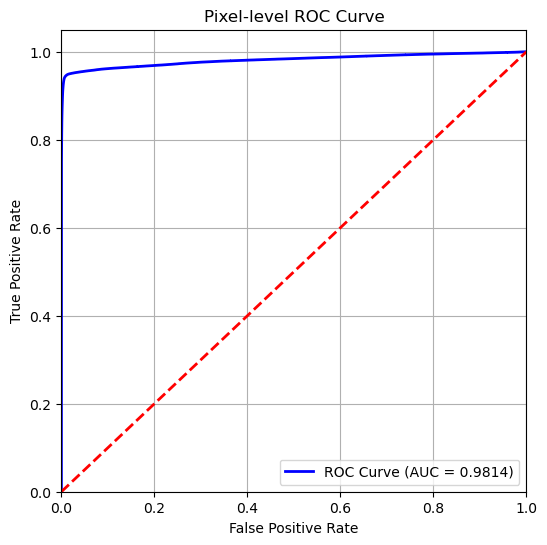

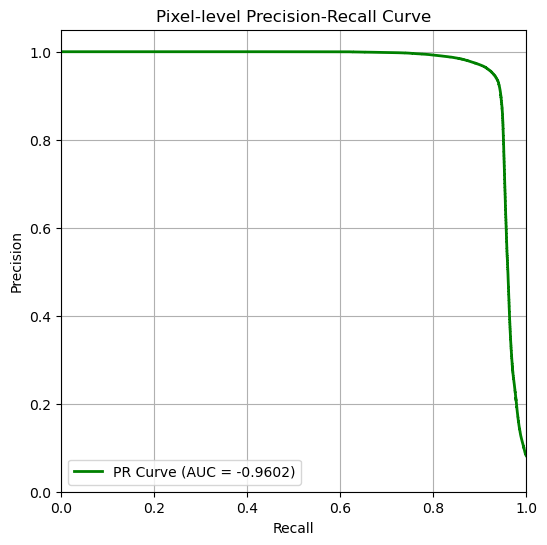

(np.float64(0.9525694847106934),
 np.float64(0.9101687371730804),
 np.float64(0.9923370679219563),
 np.float64(0.9813854121364534),
 np.float64(-0.9601864041362235))

In [12]:
def evaluate(model, dataloader, device):
    model.eval()
    dice_scores = []
    iou_scores = []
    pixel_accuracies = []
    
    all_masks = []
    all_outputs = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            
            
            masks = (masks > 100/255).to(device).float()
            
            raw_outputs = model(images)  
            probs = torch.sigmoid(raw_outputs)  
            preds = (probs > 0.5).float()

            
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            
            probs_flat = probs.view(-1)  

            
            intersection = (preds_flat * masks_flat).sum()
            dice_score = (2. * intersection + 1e-6) / (preds_flat.sum() + masks_flat.sum() + 1e-6)
            dice_scores.append(dice_score.item())

            
            union = preds_flat.sum() + masks_flat.sum() - intersection
            iou_score = (intersection + 1e-6) / (union + 1e-6)
            iou_scores.append(iou_score.item())

            
            correct = (preds_flat == masks_flat).sum()
            total = preds_flat.numel()
            pixel_accuracy = correct.item() / total
            pixel_accuracies.append(pixel_accuracy)
            
            
            all_masks.append(masks_flat.detach().cpu().numpy())
            all_outputs.append(probs_flat.detach().cpu().numpy())

    
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)
    avg_accuracy = np.mean(pixel_accuracies)

    print(f"Average Dice Coefficient: {avg_dice:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Pixel Accuracy: {avg_accuracy:.4f}")

    
    all_masks_np = np.concatenate(all_masks)
    all_outputs_np = np.concatenate(all_outputs)

    
    fpr, tpr, thresholds = roc_curve(all_masks_np, all_outputs_np)
    roc_auc = auc(fpr, tpr)

    
    precision, recall, pr_thresholds = precision_recall_curve(all_masks_np, all_outputs_np)
    
    pr_auc = np.trapz(precision, recall)

    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Pixel-level ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Pixel-level Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    return avg_dice, avg_iou, avg_accuracy, roc_auc, pr_auc

evaluate(model, val_loader, device)

Average Dice Coefficient: 0.9591
Average IoU: 0.9215
Average Pixel Accuracy: 0.9935


C:\Users\11439\AppData\Local\Temp\ipykernel_24956\1287712157.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = np.trapz(precision, recall)


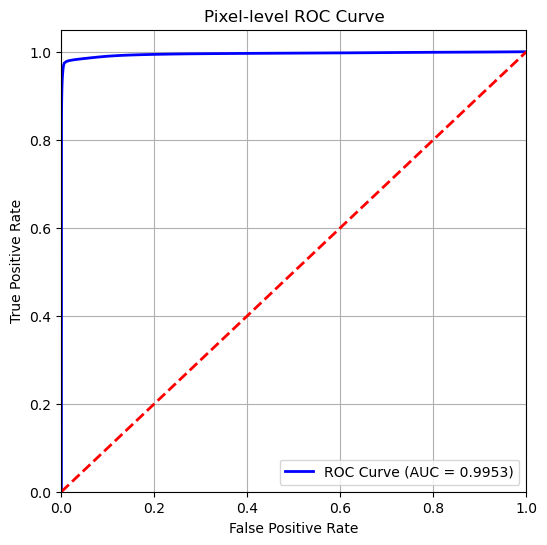

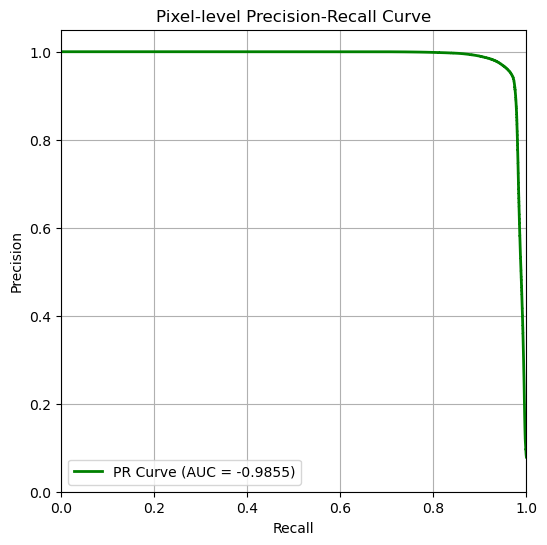

(np.float64(0.9590776324272156),
 np.float64(0.9214754343032837),
 np.float64(0.9935468355814615),
 np.float64(0.995303710410048),
 np.float64(-0.9855488127673295))

In [13]:
evaluate(model, train_loader, device)

In [24]:
len(train_dataset)

76

In [36]:
len(test_dataset)

179